In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import shap
from sklearn.ensemble import RandomForestRegressor

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('combined_data_scale-2.csv')

In [3]:
input_features = ["female1", "stunting1", "underweight1", "bcg1", "measles1", "tetanus1", 
                 "has_longterm_disease_r1", "bmi1", "carecantread1", "caregiver_is_female1", 
                 "caregiver_is_parent1", "dadage1", "dadedu1", "momage1", "momedu1",
                 "numante1", "hhsize1", "ownlandhse1", "typesite1", "cookingq1", 
                 "drwaterq1", "elecq1", "toiletq1", "aniany1", "sv1", 
                 "injury_child_may_die_r1", "sees_dad_daily_r1", "sees_mom_daily_r1", 
                 "health_worse_than_others_r1"]

output_features = ['chhealth5', 'z_selfefficacy_r5', 'z_agency_r5', 'z_selfsteem_r5', 
                  'z_peersr5', 'z_pride_r5', 'z_relationparents_r5']

In [4]:
# check missing value
print("Missing value in each col:")
print(df[input_features + output_features].isnull().sum())

df_clean = df.dropna(subset=input_features + output_features)

Missing value in each col:
female1                        0
stunting1                      0
underweight1                   0
bcg1                           0
measles1                       0
tetanus1                       0
has_longterm_disease_r1        0
bmi1                           0
carecantread1                  0
caregiver_is_female1           0
caregiver_is_parent1           0
dadage1                        0
dadedu1                        0
momage1                        0
momedu1                        0
numante1                       0
hhsize1                        0
ownlandhse1                    0
typesite1                      0
cookingq1                      0
drwaterq1                      0
elecq1                         0
toiletq1                       0
aniany1                        0
sv1                            0
injury_child_may_die_r1        0
sees_dad_daily_r1              0
sees_mom_daily_r1              0
health_worse_than_others_r1    0
chhealth5       

In [5]:
# split
X = df_clean[input_features].values
y = df_clean[output_features].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
shapley_importance = {}
selected_features_indices = {}
selected_features_names = {}

In [8]:
for i, output_name in enumerate(output_features):
    print(f" Shapley Values for {output_name}...")
    
    # use RandomForest o calculate Shapley Values
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train[:, i])
    
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_train_scaled)
    
    feature_importance = np.abs(shap_values).mean(axis=0)
    
    shapley_importance[output_name] = feature_importance
    
    # Chọn các đặc trưng có tầm quan trọng cao (ví dụ: top 60%)
    threshold = np.percentile(feature_importance, 40) 
    selected_indices = np.where(feature_importance >= threshold)[0]
    selected_features_indices[output_name] = selected_indices
    selected_features_names[output_name] = [input_features[j] for j in selected_indices]
    
    print(f" {len(selected_indices)} important with {output_name}")

 Shapley Values for chhealth5...
 17 important with chhealth5
 Shapley Values for z_selfefficacy_r5...
 17 important with z_selfefficacy_r5
 Shapley Values for z_agency_r5...
 17 important with z_agency_r5
 Shapley Values for z_selfsteem_r5...
 17 important with z_selfsteem_r5
 Shapley Values for z_peersr5...
 17 important with z_peersr5
 Shapley Values for z_pride_r5...
 17 important with z_pride_r5
 Shapley Values for z_relationparents_r5...
 17 important with z_relationparents_r5


In [9]:
# model
def build_model(input_dim, output_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(output_dim, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

# model for each output
def build_single_output_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

In [10]:
model_all_features = build_model(X_train_scaled.shape[1], y_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_all = model_all_features.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# evaluate
y_pred_all = model_all_features.predict(X_test_scaled)

r2_scores_all = {}
for i, feature in enumerate(output_features):
    r2 = r2_score(y_test[:, i], y_pred_all[:, i])
    r2_scores_all[feature] = r2
    print(f"R²: {feature}: {r2:.4f}")

print(f"R²: {np.mean(list(r2_scores_all.values())):.4f}")

# Build model for each output
print("\nBuild model for each output...")
models = {}
histories = {}
r2_scores = {}

for i, output_name in enumerate(output_features):
    print(f"\nTraining model for {output_name}...")
    
    selected_indices = selected_features_indices[output_name]
    X_train_selected = X_train_scaled[:, selected_indices]
    X_test_selected = X_test_scaled[:, selected_indices]
    y_train_single = y_train[:, i].reshape(-1, 1)
    y_test_single = y_test[:, i].reshape(-1, 1)
    
    # build and train
    model = build_single_output_model(X_train_selected.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    history = model.fit(
        X_train_selected, y_train_single,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # evaluate
    y_pred = model.predict(X_test_selected)
    r2 = r2_score(y_test_single, y_pred)
    
    # Lưu trữ kết quả
    models[output_name] = model
    histories[output_name] = history
    r2_scores[output_name] = r2
    
    print(f"R² of {output_name}: {r2:.4f}")

print(f"R²: {np.mean(list(r2_scores.values())):.4f}")

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5321 - val_loss: 1.0815
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0965 - val_loss: 1.0210
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0016 - val_loss: 1.0030
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9076 - val_loss: 0.9931
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8993 - val_loss: 0.9902
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9418 - val_loss: 0.9875
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8840 - val_loss: 0.9859
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8818 - val_loss: 0.9848
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8608 - val_loss: 0.9837
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8702 - val_loss: 0.9825
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8599 - val_loss: 0.9815
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8

In [11]:
feature_importance = pd.DataFrame(index=input_features)

# Shapley Values
print("\n Shapley Values...")
for i, output_name in enumerate(output_features):
    print(f"\n Shapley for {output_name}...")
    
    selected_indices = selected_features_indices[output_name]
    selected_names = selected_features_names[output_name]
    
    importance_values = shapley_importance[output_name][selected_indices]
    total_importance = np.sum(importance_values)
    percentage_importance = (importance_values / total_importance) * 100
    
    # Tạo dictionary ánh xạ từ tên đặc trưng đến phần trăm ảnh hưởng
    importance_dict = {input_features[idx]: pct for idx, pct in zip(selected_indices, percentage_importance)}
    
    # Gán giá trị 0 cho các đặc trưng không được chọn
    for feature in input_features:
        if feature in selected_names:
            feature_importance.loc[feature, output_name] = importance_dict[feature]
        else:
            feature_importance.loc[feature, output_name] = 0


 Shapley Values...

 Shapley for chhealth5...

 Shapley for z_selfefficacy_r5...

 Shapley for z_agency_r5...

 Shapley for z_selfsteem_r5...

 Shapley for z_peersr5...

 Shapley for z_pride_r5...

 Shapley for z_relationparents_r5...



Top 10 features :
           average_importance
bmi1                18.559515
dadage1              9.382004
momage1              8.601622
dadedu1              8.221980
momedu1              7.401480
hhsize1              6.240121
numante1             6.016288
female1              5.362899
stunting1            4.245093
typesite1            4.090658


/var/folders/31/hfnc4fhs6ks15s0ltm_17qc40000gn/T/ipykernel_35643/1484268997.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_sorted['average_importance'].values,


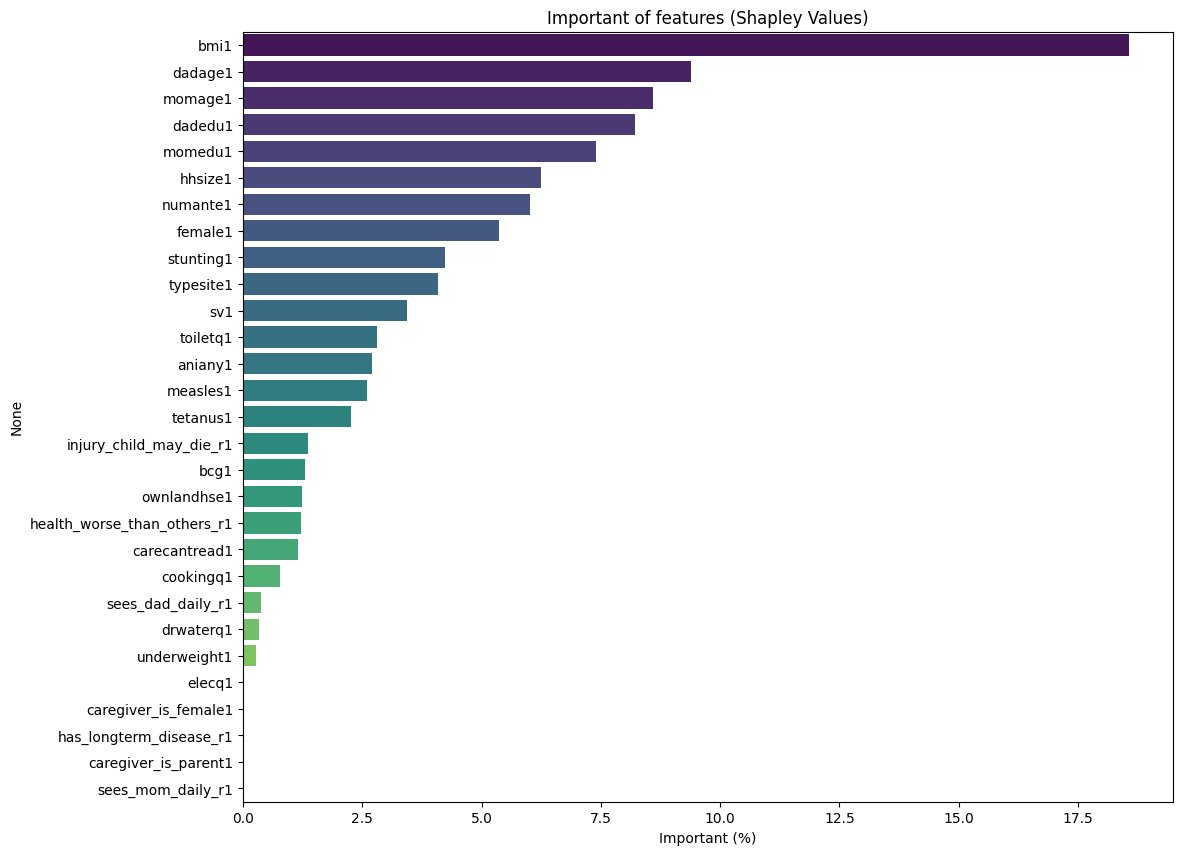

In [13]:
feature_importance['average_importance'] = feature_importance.mean(axis=1)
feature_importance_sorted = feature_importance.sort_values('average_importance', ascending=False)

print("\nTop 10 features :")
top_10 = feature_importance_sorted[['average_importance']].head(10)
top_10_display = top_10.copy()
print(top_10_display)

# Vẽ biểu đồ tầm quan trọng trung bình
plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importance_sorted['average_importance'].values, 
            y=feature_importance_sorted.index, 
            palette='viridis')
plt.title('Important of features (Shapley Values)')
plt.xlabel('Important (%)')
# plt.tight_layout()
# plt.savefig('feature_importance_average_shapley.png')
# plt.close()
plt.show()



In [16]:
top_features_per_output = {}
for output in output_features:
    sorted_features = feature_importance.sort_values(output, ascending=False)
    # Lọc ra các đặc trưng có tầm quan trọng > 0
    important_features = sorted_features[sorted_features[output] > 0]
    top_features_per_output[output] = important_features.index[:5].tolist()

print("\nThe most important features for each skills:")
for output, features in top_features_per_output.items():
    print(f"\n{output}:")
    total_importance = feature_importance[output][features].sum()
    for i, feature in enumerate(features):
        importance_pct = feature_importance.loc[feature, output]
        relative_pct = (importance_pct / total_importance) * 100 if total_importance > 0 else 0
        print(f"  {i+1}. {feature}: {relative_pct:.2f}%")

# Tìm các đặc trưng chung giữa các cặp kỹ năng
common_features = {}
for i, output1 in enumerate(output_features):
    for j, output2 in enumerate(output_features):
        if i < j: 
            top_features1 = top_features_per_output[output1]
            top_features2 = top_features_per_output[output2]
            common = set(top_features1).intersection(set(top_features2))
            if common:
                key = f"{output1} & {output2}"
                common_features[key] = list(common)

print("\nSkills have common features:")
for pair, features in common_features.items():
    print(f"\n{pair}:")
    for feature in features:
        importance1 = feature_importance.loc[feature, pair.split(' & ')[0]]
        importance2 = feature_importance.loc[feature, pair.split(' & ')[1]]
        print(f"  - {feature}: {importance1:.2f}% in {pair.split(' & ')[0]}, {importance2:.2f}% in {pair.split(' & ')[1]}")

# Tìm các đặc trưng ảnh hưởng đến nhiều kỹ năng
feature_to_skills = {}
for feature in input_features:
    skills = []
    for output in output_features:
        if feature in top_features_per_output[output][:3]: 
            skills.append(output)
    if skills:
        feature_to_skills[feature] = skills

for feature, skills in sorted(feature_to_skills.items(), key=lambda x: len(x[1]), reverse=True):
    if len(skills) > 1: 
        print(f"\n{feature} important with {len(skills)} skills:")
        for skill in skills:
            importance = feature_importance.loc[feature, skill]
            print(f"  - {skill}: {importance:.2f}%")


The most important features for each skills:

chhealth5:
  1. bmi1: 38.36%
  2. dadedu1: 17.26%
  3. momage1: 16.59%
  4. dadage1: 15.51%
  5. female1: 12.27%

z_selfefficacy_r5:
  1. bmi1: 41.03%
  2. momedu1: 17.21%
  3. dadage1: 15.44%
  4. momage1: 14.71%
  5. dadedu1: 11.62%

z_agency_r5:
  1. bmi1: 33.95%
  2. female1: 25.48%
  3. momedu1: 14.01%
  4. momage1: 13.77%
  5. dadage1: 12.78%

z_selfsteem_r5:
  1. typesite1: 28.81%
  2. bmi1: 25.60%
  3. dadedu1: 17.31%
  4. dadage1: 15.42%
  5. momage1: 12.85%

z_peersr5:
  1. bmi1: 29.65%
  2. momage1: 20.99%
  3. dadage1: 18.29%
  4. typesite1: 15.91%
  5. stunting1: 15.16%

z_pride_r5:
  1. bmi1: 32.98%
  2. dadage1: 22.50%
  3. numante1: 18.04%
  4. dadedu1: 13.78%
  5. momage1: 12.70%

z_relationparents_r5:
  1. bmi1: 29.18%
  2. dadedu1: 19.35%
  3. dadage1: 17.48%
  4. momedu1: 17.32%
  5. momage1: 16.67%

Skills have common features:

chhealth5 & z_selfefficacy_r5:
  - dadage1: 9.14% in chhealth5, 8.76% in z_selfefficacy_r5
